<a href="https://colab.research.google.com/github/AlexKinda1/Projet-InsightBoost/blob/main/D%C3%A9tection_du_glaucome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PHASE 1: EXPLORATION DES DONNEES
###ETAPE 1.1: Chargement et Analyse du fichier de labels

connexion à google drive
Mounted at /content/drive
Connexion réussie

 Fichier 'Labels.csv' chargé avec succès.

--- Analyse de la Distribution des Classes ---
Label
GON+    548
GON-    199
Name: count, dtype: int64

--- Affichage d'un exemple pour chaque classe ---


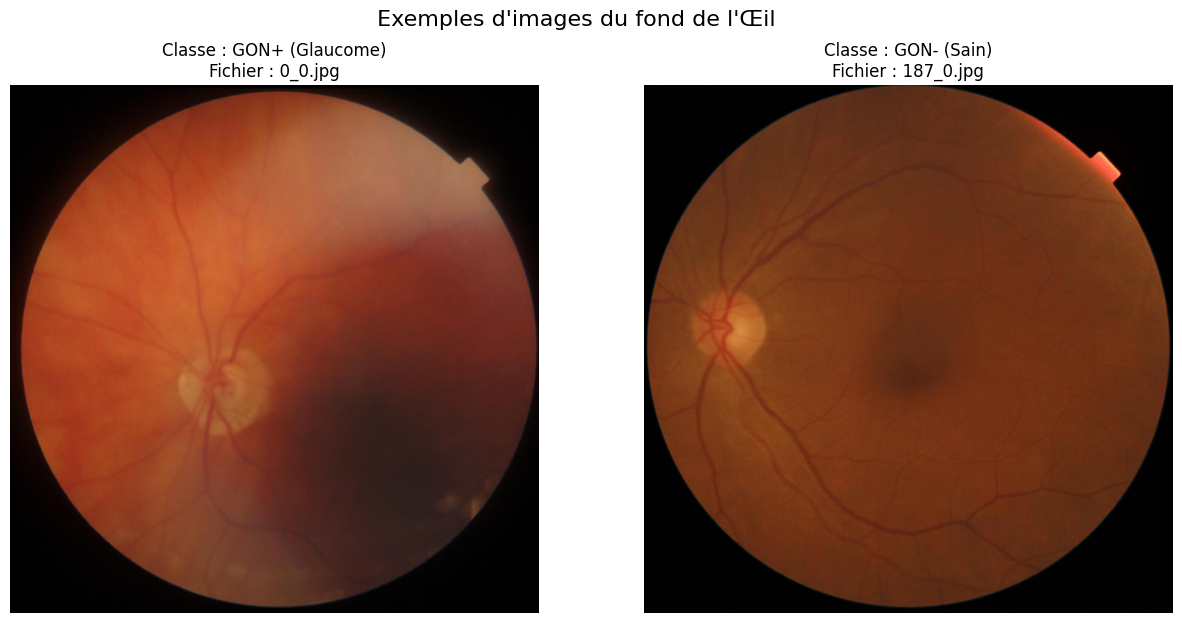

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from google.colab import drive

print("connexion à google drive")
drive.mount('/content/drive')
print("Connexion réussie")

BASE_PATH = '/content/drive/My Drive/Projet_Glaucome/'

CSV_PATH = os.path.join(BASE_PATH, 'Labels.csv')
IMAGE_PATH = os.path.join(BASE_PATH, 'images/')

try:
    df_labels = pd.read_csv(CSV_PATH)
    print("\n Fichier 'Labels.csv' chargé avec succès.")

    print("\n--- Analyse de la Distribution des Classes ---")
    class_distribution = df_labels['Label'].value_counts()
    print(class_distribution)


    print("\n--- Affichage d'un exemple pour chaque classe ---")
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Image Glaucomateuse (GON+)
    sample_gon_plus = df_labels[df_labels['Label'] == 'GON+'].iloc[0]
    full_path_plus = os.path.join(IMAGE_PATH, sample_gon_plus['Image Name'])
    image_plus = cv2.imread(full_path_plus)
    image_plus = cv2.cvtColor(image_plus, cv2.COLOR_BGR2RGB)
    axes[0].imshow(image_plus)
    axes[0].set_title(f"Classe : GON+ (Glaucome)\nFichier : {sample_gon_plus['Image Name']}", fontsize=12)
    axes[0].axis('off')

    # Image Saine (GON-)
    sample_gon_minus = df_labels[df_labels['Label'] == 'GON-'].iloc[0]
    full_path_minus = os.path.join(IMAGE_PATH, sample_gon_minus['Image Name'])
    image_minus = cv2.imread(full_path_minus)
    image_minus = cv2.cvtColor(image_minus, cv2.COLOR_BGR2RGB)
    axes[1].imshow(image_minus)
    axes[1].set_title(f"Classe : GON- (Sain)\nFichier : {sample_gon_minus['Image Name']}", fontsize=12)
    axes[1].axis('off')

    plt.suptitle(" Exemples d'images du fond de l'Œil", fontsize=16)
    plt.show()

except FileNotFoundError:
    print(f"\nERREUR : Le fichier ou le dossier est toujours introuvable.")
    print(f"Veuillez vérifier que le chemin suivant est 100% correct : {BASE_PATH}")
except Exception as e:
    print(f"Une erreur est survenue : {e}")

# Phase 2 : Prétraitement et Augmentation des Données
### **1. Séparation Stratifiée des Données** : Nous allons diviser notre jeu de données en trois sous-ensembles distincts : Training Set (75%), Validation Set (15%), Test Set (15%)

### **2. Data Augmentation**: Transformations aléatoires : rotations, zooms, légers décalages, etc.

### **3. Création des générateurs de données**


In [2]:
# Séparation stratifiée des données
X_train, X_temp, y_train, y_temp = train_test_split(
    df_labels['Image Name'],
    df_labels['Label'],
    test_size = 0.3,
    random_state = 42,
    stratify = df_labels['Label']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

train_df = pd.DataFrame({'Image Name':X_train, 'Label': y_train})
validation_df = pd.DataFrame({'Image Name': X_val, 'Label': y_val})
test_df = pd.DataFrame({'Image Name': X_test, 'Label': y_test})

print("\n Repartition des données")
print(f"Taille de l'ensemble d'entrainement: {len(train_df)} images")
print(f"Taille de l'ensemble de validation: {len(validation_df)} images")
print(f"Taille de l'ensemble de test: {len(test_df)} images")
print("\n Distribution dans l'ensemble d'entrainement")
print(train_df['Label'].value_counts(normalize=True))
print("\nDistribution dans l'ensemble de validation :")
print(validation_df['Label'].value_counts(normalize=True))


 Repartition des données
Taille de l'ensemble d'entrainement: 522 images
Taille de l'ensemble de validation: 112 images
Taille de l'ensemble de test: 113 images

 Distribution dans l'ensemble d'entrainement
Label
GON+    0.733716
GON-    0.266284
Name: proportion, dtype: float64

Distribution dans l'ensemble de validation :
Label
GON+    0.732143
GON-    0.267857
Name: proportion, dtype: float64


In [3]:
# Configuration des Générateurs d'Images
IMG_SIZE = 224
BATCH_SIZE = 32

# Generateur pour l'entrainement
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 10,
    height_shift_range = 10,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

# Générateur pour la validation et le test (SANS augmentation)
val_test_datagen = ImageDataGenerator(
    rescale = 1./255
)

# Création des flux de données depuis les DataFrames
print("Création des générateurs de données")

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_PATH,
    x_col='Image Name',
    y_col='Label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=IMAGE_PATH,
    x_col='Image Name',
    y_col='Label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMAGE_PATH,
    x_col='Image Name',
    y_col='Label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Surtout ne pas mélanger les données de test pour une évaluation reproductible.
)


Création des générateurs de données
Found 522 validated image filenames belonging to 2 classes.
Found 112 validated image filenames belonging to 2 classes.
Found 113 validated image filenames belonging to 2 classes.


In [ ]:
from google.colab import files
import os

files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\ API Kaggle configurée avec succès !")

Saving kaggle.json to kaggle.json
\ API Kaggle configurée avec succès !


In [ ]:
!kaggle datasets download -d victorlemosml/refuge2

print("Téléchargement terminé")

!unzip -q refuge2.zip

print("Décompression terminée.")

Dataset URL: https://www.kaggle.com/datasets/victorlemosml/refuge2
License(s): unknown
refuge2.zip: Skipping, found more recently modified local copy (use --force to force download)
Téléchargement terminé
replace REFUGE2/test/images/T0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Décompression terminée.


In [ ]:
!ls -R

.:
kaggle.json  REFUGE2  refuge2.zip  sample_data

./REFUGE2:
test  train  val

./REFUGE2/test:
images	mask

./REFUGE2/test/images:
T0001.jpg  T0059.jpg  T0117.jpg  T0175.jpg  T0233.jpg  T0291.jpg  T0349.jpg
T0002.jpg  T0060.jpg  T0118.jpg  T0176.jpg  T0234.jpg  T0292.jpg  T0350.jpg
T0003.jpg  T0061.jpg  T0119.jpg  T0177.jpg  T0235.jpg  T0293.jpg  T0351.jpg
T0004.jpg  T0062.jpg  T0120.jpg  T0178.jpg  T0236.jpg  T0294.jpg  T0352.jpg
T0005.jpg  T0063.jpg  T0121.jpg  T0179.jpg  T0237.jpg  T0295.jpg  T0353.jpg
T0006.jpg  T0064.jpg  T0122.jpg  T0180.jpg  T0238.jpg  T0296.jpg  T0354.jpg
T0007.jpg  T0065.jpg  T0123.jpg  T0181.jpg  T0239.jpg  T0297.jpg  T0355.jpg
T0008.jpg  T0066.jpg  T0124.jpg  T0182.jpg  T0240.jpg  T0298.jpg  T0356.jpg
T0009.jpg  T0067.jpg  T0125.jpg  T0183.jpg  T0241.jpg  T0299.jpg  T0357.jpg
T0010.jpg  T0068.jpg  T0126.jpg  T0184.jpg  T0242.jpg  T0300.jpg  T0358.jpg
T0011.jpg  T0069.jpg  T0127.jpg  T0185.jpg  T0243.jpg  T0301.jpg  T0359.jpg
T0012.jpg  T0070.jpg  T0128.jpg 

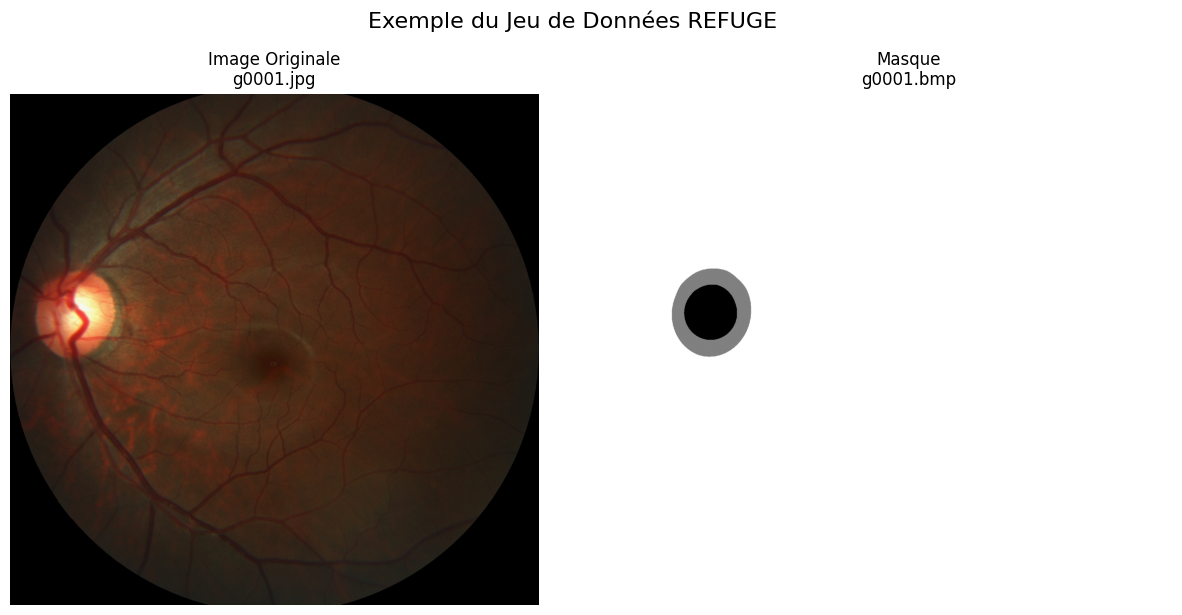

In [ ]:
import matplotlib.pyplot as plt
import cv2

refuge_images_path = 'REFUGE2/train/images'
refuge_masks_path = 'REFUGE2/train/mask'

refuge_images = sorted(os.listdir(refuge_images_path))
refuge_masks = sorted(os.listdir(refuge_masks_path))

#Visualisation
sample_image_name = refuge_images[0]
sample_mask_name = refuge_masks[0]

sample_image = cv2.imread(os.path.join(refuge_images_path, sample_image_name))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

sample_mask = cv2.imread(os.path.join(refuge_masks_path, sample_mask_name), cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(sample_image)
axes[0].set_title(f"Image Originale\n{sample_image_name}")
axes[0].axis('off')

axes[1].imshow(sample_mask, cmap='gray')
axes[1].set_title(f"Masque\n{sample_mask_name}")
axes[1].axis('off')

plt.suptitle("Exemple du Jeu de Données REFUGE", fontsize=16)
plt.show()

Trouvé 320 images pour l'entraînement.
Trouvé 80 images pour la validation.

✅ Pipeline de données tf.data robuste créé avec succès.

✅ Modèle U-Net construit et compilé.

--- Lancement de l'entraînement du U-Net ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 191s 8s/step - dice_coeff: 0.8314 - loss: 0.4048 - val_dice_coeff: 0.9747 - val_loss: 0.1651
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 164s 8s/step - dice_coeff: 0.9801 - loss: 0.1191 - val_dice_coeff: 0.9932 - val_loss: 0.0481
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 159s 8s/step - dice_coeff: 0.9915 - loss: 0.0432 - val_dice_coeff: 0.9940 - val_loss: 0.0308
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 155s 8s/step - dice_coeff: 0.9912 - loss: 0.0339 - val_dice_coeff: 0.9943 - val_loss: 0.0253
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 155s 8s/step - dice_coeff: 0.9931 - loss: 0.0251 - val_dice_coeff: 0.9942 - val_loss: 0.0208
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 168s 8s/step - dice_coeff: 0.9927 - loss: 0.0256 - val_dice_coeff: 0.9941 - val_loss: 0.0191
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step - dice_coeff: 0.9935 - loss: 0.0242 - val_dice_coeff: 0.9940 - val_loss: 0.0180
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 155s 8s/step - dice_coeff: 0.9938 - loss: 0.0199 - val_d

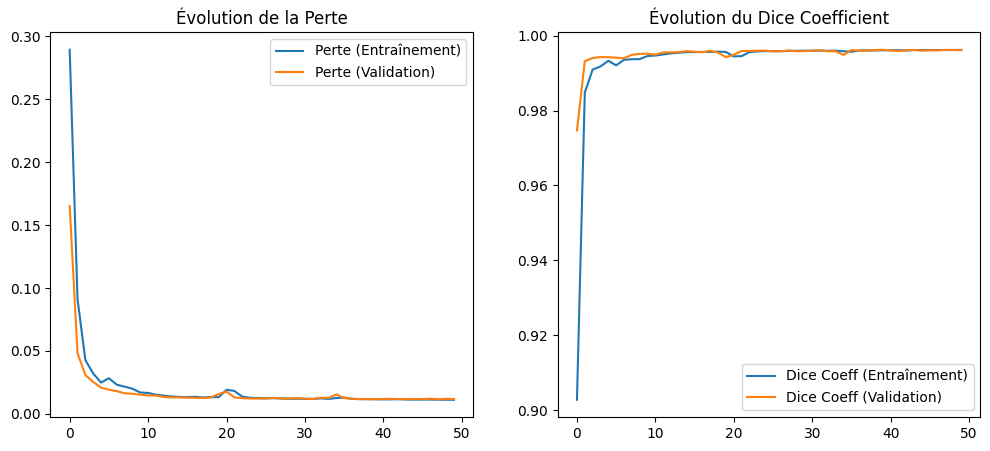

In [ ]:
import tensorflow as tf
import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import numpy as np

BASE_PATH = '/content/drive/My Drive/Projet_Glaucome/'

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16


all_train_image_paths = sorted(glob.glob("REFUGE2/train/images/*.jpg"))
all_train_mask_paths = sorted(glob.glob("REFUGE2/train/mask/*.bmp"))

train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    all_train_image_paths,
    all_train_mask_paths,
    test_size=0.2,
    random_state=42
)
print(f"Trouvé {len(train_image_paths)} images pour l'entraînement.")
print(f"Trouvé {len(val_image_paths)} images pour la validation.")

# --- C. Création du pipeline tf.data (SOLUTION ROBUSTE) ---
def load_and_preprocess_wrapper(image_path, mask_path):

    image, mask = tf.py_function(func=load_with_opencv,
                                 inp=[image_path, mask_path],
                                 Tout=[tf.float32, tf.float32])

    image.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
    return image, mask

def load_with_opencv(image_path, mask_path):

    image_path = image_path.numpy().decode('utf-8')
    mask_path = mask_path.numpy().decode('utf-8')

    # Charger l'image avec OpenCV
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convertir en RGB
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = image / 255.0

    # Charger le masque avec OpenCV en niveaux de gris
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = mask / 255.0
    # Ajouter une dimension de canal pour correspondre à la sortie du modèle
    mask = np.expand_dims(mask, axis=-1)

    return image.astype(np.float32), mask.astype(np.float32)

# Création des datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_dataset = train_dataset.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))
val_dataset = val_dataset.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

# Préparation pour l'entraînement
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(len(train_image_paths)).batch(BATCH_SIZE).repeat().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
print("\n Pipeline de données tf.data robuste créé avec succès.")


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

def build_unet(input_shape):
    inputs = Input(input_shape)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def dice_coeff(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

unet_model = build_unet((IMG_HEIGHT, IMG_WIDTH, 3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coeff])
print("\n Modèle U-Net construit et compilé.")


print("\n--- Lancement de l'entraînement du U-Net ---")

EPOCHS_UNET = 50
steps_per_epoch = len(train_image_paths) // BATCH_SIZE
validation_steps = len(val_image_paths) // BATCH_SIZE

history_unet = unet_model.fit(
    train_dataset,
    epochs=EPOCHS_UNET,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

# Sauvegarder le modèle
unet_model_path = os.path.join(BASE_PATH, 'unet_optic_disc_segmentation.keras')
unet_model.save(unet_model_path)
print(f"\n Entraînement du U-Net terminé ! Modèle sauvegardé à : {unet_model_path}")

# --- F. Visualisation de la performance ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_unet.history['loss'], label='Perte (Entraînement)')
plt.plot(history_unet.history['val_loss'], label='Perte (Validation)')
plt.title('Évolution de la Perte')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_unet.history['dice_coeff'], label='Dice Coeff (Entraînement)')
plt.plot(history_unet.history['val_dice_coeff'], label='Dice Coeff (Validation)')
plt.title('Évolution du Dice Coefficient')
plt.legend()
plt.show()

--- Évaluation visuelle du modèle U-Net ---


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


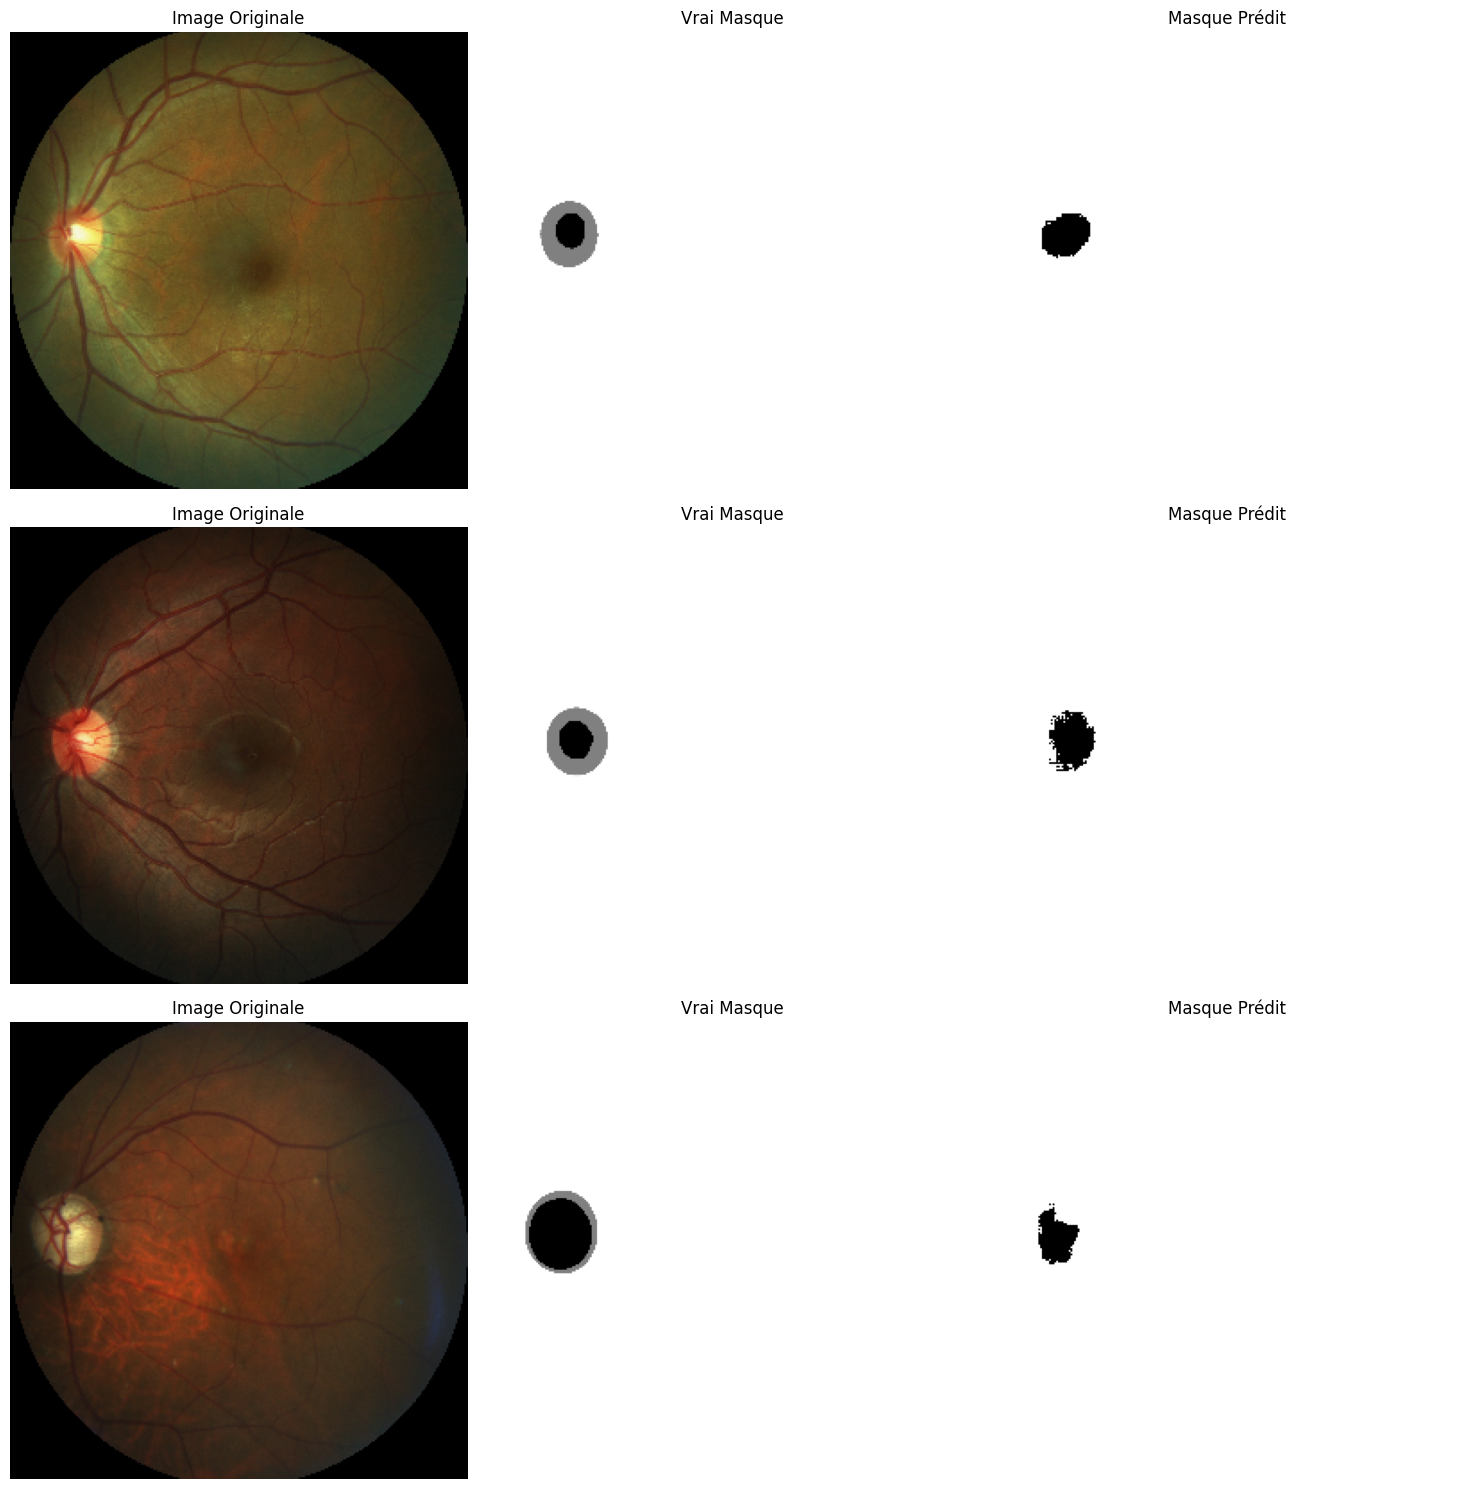

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print("--- Évaluation visuelle du modèle U-Net ---")


val_images, val_masks = next(iter(val_dataset.take(1)))

# On utilise le U-Net pour prédire les masques sur ce lot d'images
predicted_masks = unet_model.predict(val_images)

# Afficher quelques exemples (par exemple les 3 premiers)
num_examples_to_show = 3
plt.figure(figsize=(15, num_examples_to_show * 5))

for i in range(num_examples_to_show):
    # Affichage de l'image originale
    plt.subplot(num_examples_to_show, 3, i*3 + 1)
    plt.imshow(val_images[i])
    plt.title("Image Originale")
    plt.axis('off')

    # Affichage du vrai masque
    plt.subplot(num_examples_to_show, 3, i*3 + 2)
    plt.imshow(np.squeeze(val_masks[i]), cmap='gray')
    plt.title("Vrai Masque")
    plt.axis('off')

    # Affichage du masque prédit
    # On utilise un seuil de 0.5 pour binariser la sortie du modèle (probabilités)
    predicted_mask_binary = (predicted_masks[i] > 0.5).astype(np.uint8)
    plt.subplot(num_examples_to_show, 3, i*3 + 3)
    plt.imshow(np.squeeze(predicted_mask_binary), cmap='gray')
    plt.title("Masque Prédit")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tqdm import tqdm


unet_model_path = os.path.join(BASE_PATH, 'unet_optic_disc_segmentation.keras')

# On ajoute le `custom_objects` pour qu'il reconnaisse notre métrique personnalisée
unet_model = tf.keras.models.load_model(unet_model_path, custom_objects={'dice_coeff': dice_coeff})
print(" Modèle U-Net chargé.")


# Chemin vers vos images originales
original_images_path = os.path.join(BASE_PATH, 'images/')

# Création d'un nouveau dossier pour les images recadrées
cropped_images_path = os.path.join(BASE_PATH, 'cropped_images/')
os.makedirs(cropped_images_path, exist_ok=True)
print(f"Les images recadrées seront sauvegardées dans : {cropped_images_path}")


# On utilise le DataFrame original `df_labels` qui contient le nom de toutes vos images
image_filenames = df_labels['Image Name'].tolist()

print("\n--- Début du processus de prédiction et de recadrage ---")

for filename in tqdm(image_filenames):
    try:
        # 1. Charger l'image originale
        img_path = os.path.join(original_images_path, filename)
        original_img = cv2.imread(img_path)
        original_h, original_w, _ = original_img.shape

        # 2. Prétraiter l'image pour le U-Net
        img_for_unet = cv2.resize(original_img, (IMG_WIDTH, IMG_HEIGHT))
        img_for_unet = img_for_unet / 255.0
        img_for_unet = np.expand_dims(img_for_unet, axis=0) # Ajouter la dimension du lot

        # 3. Prédire le masque
        predicted_mask_normalized = unet_model.predict(img_for_unet, verbose=0)
        predicted_mask = (predicted_mask_normalized[0] * 255).astype(np.uint8)

        # 4. Trouver les contours du disque optique sur le masque prédit
        contours, _ = cv2.findContours(predicted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # On prend le plus grand contour trouvé
            largest_contour = max(contours, key=cv2.contourArea)
            # On calcule la boîte de délimitation (bounding box)
            x, y, w, h = cv2.boundingRect(largest_contour)

            # 5. Redimensionner les coordonnées de la boîte pour l'image originale
            x_orig = int(x * original_w / IMG_WIDTH)
            y_orig = int(y * original_h / IMG_HEIGHT)
            w_orig = int(w * original_w / IMG_WIDTH)
            h_orig = int(h * original_h / IMG_HEIGHT)

            # Ajouter une petite marge de sécurité (10%)
            margin_w = int(w_orig * 0.10)
            margin_h = int(h_orig * 0.10)

            x_orig = max(0, x_orig - margin_w)
            y_orig = max(0, y_orig - margin_h)
            w_orig = min(original_w - x_orig, w_orig + 2 * margin_w)
            h_orig = min(original_h - y_orig, h_orig + 2 * margin_h)

            # 6. Recadrer l'image originale
            cropped_img = original_img[y_orig:y_orig+h_orig, x_orig:x_orig+w_orig]

            # 7. Sauvegarder l'image recadrée
            save_path = os.path.join(cropped_images_path, filename)
            cv2.imwrite(save_path, cropped_img)
        else:
            print(f"Aucun contour trouvé pour l'image {filename}. L'image n'est pas recadrée.")

    except Exception as e:
        print(f"Erreur lors du traitement de {filename}: {e}")

print("\n Processus terminé ! Votre nouveau jeu de données d'images recadrées est prêt.")

✅ Modèle U-Net chargé.
Les images recadrées seront sauvegardées dans : /content/drive/My Drive/Projet_Glaucome/cropped_images/

--- Début du processus de prédiction et de recadrage ---


100%|██████████| 747/747 [06:54<00:00,  1.80it/s]


🎉 Processus terminé ! Votre nouveau jeu de données d'images recadrées est prêt.


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2B2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight
import numpy as np
import os

# --- A. Configuration des générateurs pour les données recadrées ---
print("--- Configuration des générateurs pour les images recadrées ---")

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes = np.unique(train_generator.classes),
    y = train_generator.classes
)

class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights))

# Le chemin pointe maintenant vers notre nouveau dossier
CROPPED_IMAGE_PATH = os.path.join(BASE_PATH, 'cropped_images/')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator_final = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=CROPPED_IMAGE_PATH,
    x_col='Image Name',
    y_col='Label',
    target_size=(260, 260), # On garde la même taille pour EfficientNet
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator_final = val_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=CROPPED_IMAGE_PATH,
    x_col='Image Name',
    y_col='Label',
    target_size=(260, 260),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# --- B. Reconstruction du modèle EfficientNetV2 ---
print("\n--- Reconstruction du classificateur EfficientNetV2 ---")
base_model_final = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))
base_model_final.trainable = False

x = base_model_final.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # On garde une régularisation forte
outputs = Dense(1, activation='sigmoid')(x)
final_model = Model(inputs=base_model_final.input, outputs=outputs)

# 1. Entraînement de la tête
print("\n--- Étape 1 : Entraînement de la tête sur les données recadrées ---")
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# On réutilise les poids de classe et les callbacks
# On sauvegarde le nouveau meilleur modèle dans un fichier différent
best_model_final_path = os.path.join(BASE_PATH, 'final_glaucoma_classifier.keras')
checkpoint_final = ModelCheckpoint(filepath=best_model_final_path, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_auc', mode='max', patience=10, verbose=1, restore_best_weights=True)

history_head_final = final_model.fit(
    train_generator_final, epochs=50, validation_data=validation_generator_final,
    class_weight=class_weights_dict, callbacks=[checkpoint_final, early_stopping]
)

# 2. Fine-tuning
print("\n--- Étape 2 : Fine-tuning sur les données recadrées ---")
base_model_final.trainable = True
fine_tune_at = len(base_model_final.layers) // 2
for layer in base_model_final.layers[fine_tune_at:]:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=6e-5)
final_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

last_epoch = history_head_final.epoch[-1] if history_head_final.epoch else 0
total_epochs = last_epoch + 120

history_fine_tune_final = final_model.fit(
    train_generator_final, epochs=total_epochs, initial_epoch=last_epoch,
    validation_data=validation_generator_final, class_weight=class_weights_dict, callbacks=[checkpoint_final, early_stopping]
)

print("\n Entraînement final terminé !")

--- Configuration des générateurs pour les images recadrées ---
Found 522 validated image filenames belonging to 2 classes.
Found 112 validated image filenames belonging to 2 classes.

--- Reconstruction du classificateur EfficientNetV2 ---
35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

--- Étape 1 : Entraînement de la tête sur les données recadrées ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.4827 - auc: 0.4935 - loss: 0.7146 
Epoch 1: val_auc improved from -inf to 0.50000, saving model to /content/drive/My Drive/Projet_Glaucome/final_glaucoma_classifier.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 349s 19s/step - accuracy: 0.4874 - auc: 0.4936 - loss: 0.7149 - val_accuracy: 0.2679 - val_auc: 0.5000 - val_loss: 0.7335
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3839 - auc: 0.4444 - loss: 0.7448
Epoch 2: val_auc did not improve from 0.50000
17/17 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - accuracy: 0.3861 - auc: 0.4455 - loss: 0.7439 - val_accuracy: 0.7321 - val_auc: 0.4622 - val_loss: 0.6466
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5914 - auc: 0.4702 - loss: 0.7038
Epoch 3: val_auc did not improve from 0.50000
17/17 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - accuracy: 0.5903 - auc: 0.4715 - loss: 0.7044 - val_accuracy: 0.2679 - val_auc: 0.4894 - val_loss: 0.7062
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━

 Modèle final chargé pour l'évaluation.
Found 113 validated image filenames belonging to 2 classes.

--- Réalisation des prédictions sur l'ensemble de test recadré ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step

--- RAPPORT DE CLASSIFICATION  ---
              precision    recall  f1-score   support

        GON+       0.99      0.94      0.96        83
        GON-       0.85      0.97      0.91        30

    accuracy                           0.95       113
   macro avg       0.92      0.95      0.93       113
weighted avg       0.95      0.95      0.95       113


--- MATRICE DE CONFUSION  ---


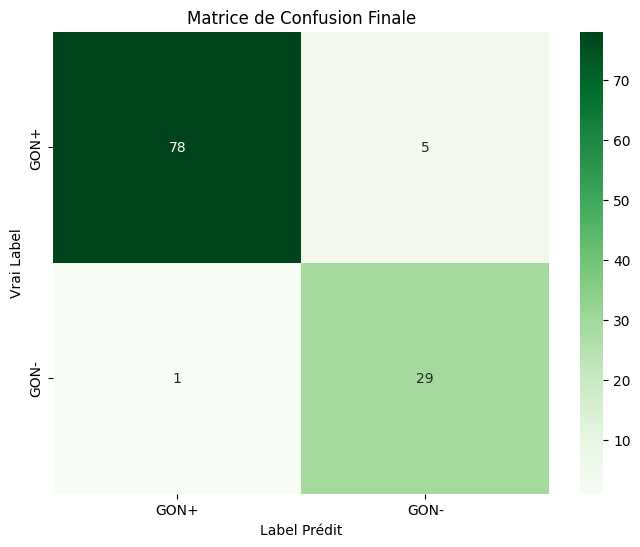

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

# --- A. Chargement du meilleur modèle final ---
best_model_final_path = os.path.join(BASE_PATH, 'final_glaucoma_classifier.keras')
final_model = tf.keras.models.load_model(best_model_final_path)
print(" Modèle final chargé pour l'évaluation.")

CROPPED_IMAGE_PATH = os.path.join(BASE_PATH, 'cropped_images/')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator_final = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=CROPPED_IMAGE_PATH,
    x_col='Image Name',
    y_col='Label',
    target_size=(260, 260),
    batch_size=1, # On évalue une image à la fois pour ne pas avoir de problème de taille de lot
    class_mode='binary',
    shuffle=False
)

# --- C. Prédictions sur l'ensemble de test ---
print("\n--- Réalisation des prédictions sur l'ensemble de test recadré ---")
predictions_proba = final_model.predict(test_generator_final)
predictions = (predictions_proba > 0.78).astype(int)

true_labels = test_generator_final.classes
class_labels = list(test_generator_final.class_indices.keys())

# --- D. Rapport de Classification Final ---
print("\n--- RAPPORT DE CLASSIFICATION  ---")
print(classification_report(true_labels, predictions, target_names=class_labels))

# --- E. Matrice de Confusion Finale ---
print("\n--- MATRICE DE CONFUSION  ---")
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matrice de Confusion Finale')
plt.ylabel('Vrai Label')
plt.xlabel('Label Prédit')
plt.show()

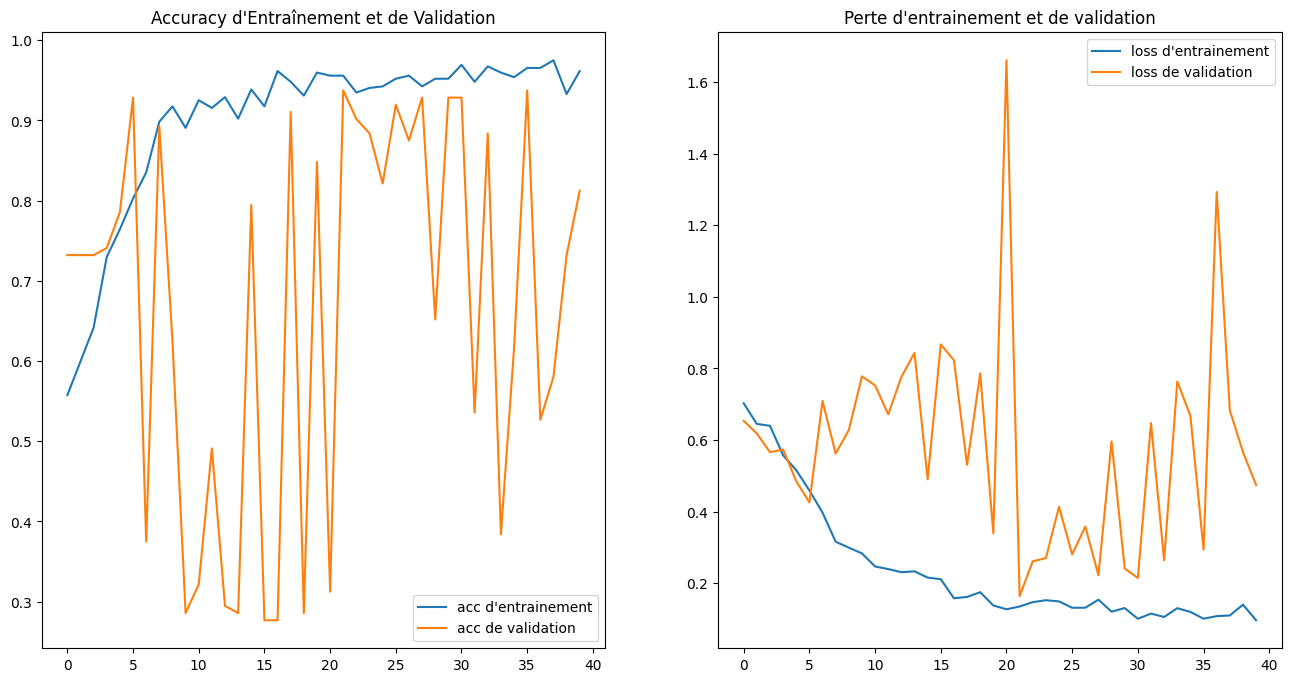

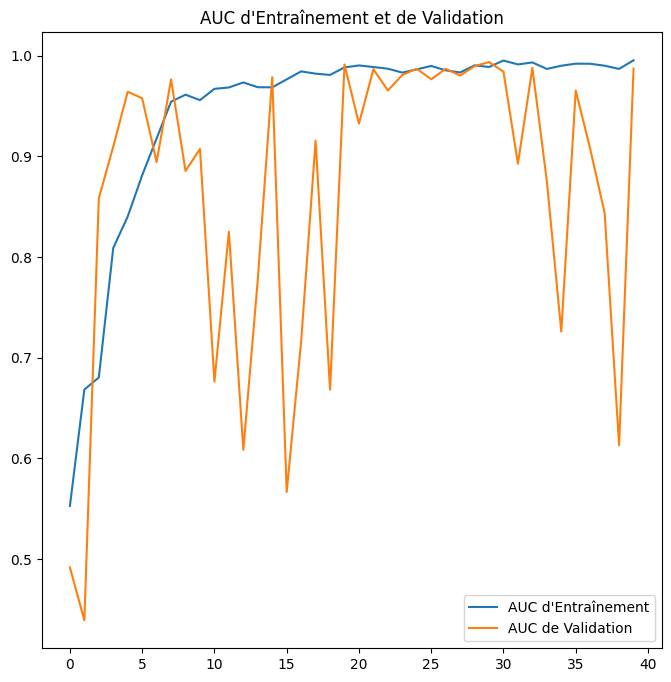

In [20]:
history_dict = history_fine_tune_final.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
auc = history_dict['auc']
val_auc = history_dict['val_auc']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label= "acc d'entrainement")
plt.plot(epochs_range, val_acc, label="acc de validation")
plt.legend(loc="lower right")
plt.title("Accuracy d'Entraînement et de Validation")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="loss d'entrainement")
plt.plot(epochs_range, val_loss, label="loss de validation")
plt.legend(loc="upper right")
plt.title("Perte d'entrainement et de validation")

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, auc, label="AUC d'Entraînement")
plt.plot(epochs_range, val_auc, label="AUC de Validation")
plt.legend(loc='lower right')
plt.title('AUC d\'Entraînement et de Validation')

plt.show()





AUC_ROC: 0.9734939759036144


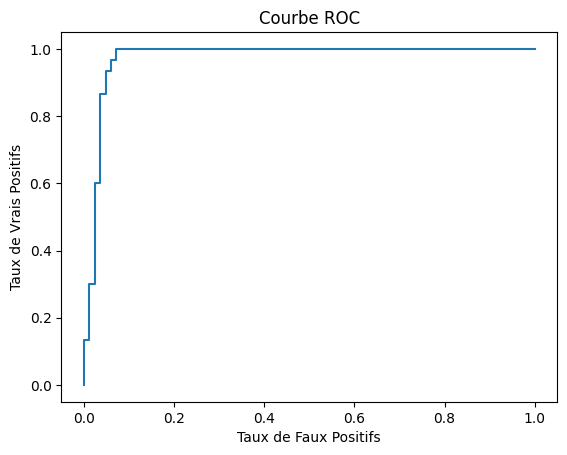

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc = roc_auc_score(true_labels, predictions_proba)
print("AUC_ROC:", roc_auc)

fpr, tpr, thresolds = roc_curve(true_labels, predictions_proba)

plt.plot(fpr, tpr, label='Courbe ROC  (AUC = {roc_auc:.2f})')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')

plt.show()
